In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import copy
import cv2 as cv
from keras.utils import Sequence
import keras.backend as K
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model

# **Prepare Dataset**

In [2]:
!unzip /content/gdrive/MyDrive/Dataset/VOC_2012/VOC2012.zip > /dev/null

In [3]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [4]:
train_image_folder = "/content/VOC2012/JPEGImages/"
train_annot_folder = "/content/VOC2012/Annotations/"

In [7]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                                                 
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


In [8]:
train_image[1]

{'object': [{'name': 'aeroplane',
   'xmin': 104,
   'ymin': 78,
   'xmax': 375,
   'ymax': 183},
  {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
  {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
  {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
 'filename': '/content/VOC2012/JPEGImages/2007_000032.jpg',
 'width': 500,
 'height': 281}

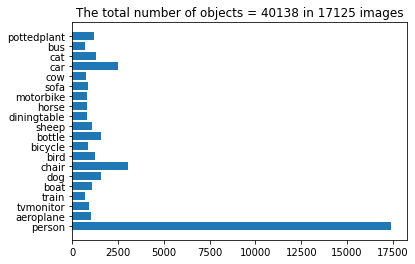

In [9]:
y_pos = np.arange(len(seen_train_labels))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))
plt.show()

# **K-means Cluster for creating anchor boxes**

In [10]:
wh_box = []

for i in train_image:
  w = float(i['width'])
  h = float(i['height'])
  for o in i['object']:
    o_w = (o['xmax'] - o['xmin']) / w
    o_h = (o['ymax'] - o['ymin']) / h
    wh_box.append([o_w, o_h])

wh_box = np.array(wh_box)

In [11]:
wh_box.shape

(40138, 2)

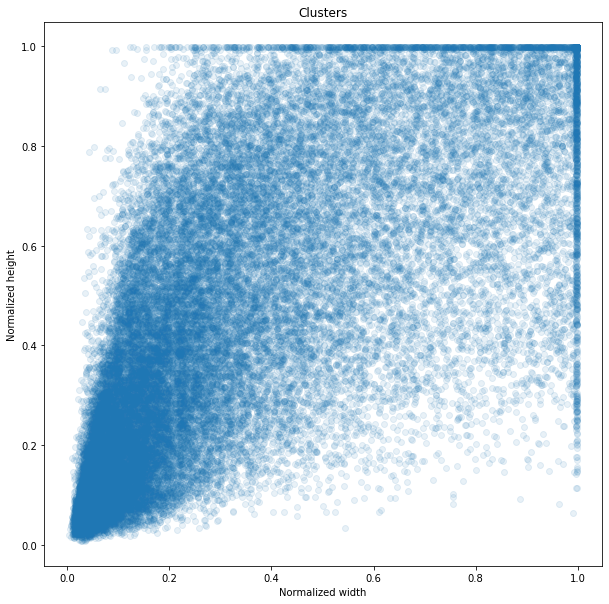

In [12]:
plt.figure(figsize=(10, 10))
plt.title("Clusters")
plt.xlabel("Normalized width")
plt.ylabel("Normalized height")
plt.scatter(wh_box[:, 0], wh_box[:, 1], alpha=0.1)
plt.show()

In [13]:
def iou(box, cluster):
  # box : [2,]
  # cluster: [n_of_gtbox, 2]
  # All box share xy_min so we just care about w and h

  X = np.minimum(cluster[:, 0], box[0])
  y = np.minimum(cluster[:, 1], box[1])

  intersection = X * y  # min(w1, w2) * min(h1, h2)

  box_area = box[0] * box[1]
  cluster_area = cluster[:, 0] * cluster[:, 1]

  union = box_area + cluster_area - intersection
  
  iou = intersection / union
  
  return iou

In [14]:
def kmeans(boxes, k, dist=np.median, seed=1):
  row = boxes.shape[0]

  # Initialize cluster center
  np.random.seed(1)
  clusters = boxes[np.random.choice(row, k, replace=False)]  # [k, 2]: Each center has cordinate w, h

  distance = np.empty((row, k)) # Matrix of distance IOU between boxes and cluster center
  last_cluster = np.zeros((row,)) # Condition to break loop

  while True:
    for i in range(k):
      distance[:, i] = 1 - iou(clusters[i], boxes) # Calculate matrix distance

    nearest_cluster = np.argmin(distance, axis=1) # [row, ]: Show which box belong to which cluster

    if (last_cluster == nearest_cluster).all():
      break

    for j in range(k):
      j_cluster = np.where(nearest_cluster == j)
      clusters[j] = np.median(boxes[j_cluster[0]], axis=0)  # Re-calculate cluster center by median

    last_cluster = nearest_cluster

  return clusters, nearest_cluster, distance

In [15]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh_box,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4592
 3 clusters: mean IoU = 0.5371
 4 clusters: mean IoU = 0.5828
 5 clusters: mean IoU = 0.6127
 6 clusters: mean IoU = 0.6318
 7 clusters: mean IoU = 0.6495
 8 clusters: mean IoU = 0.6657
 9 clusters: mean IoU = 0.6788
10 clusters: mean IoU = 0.6918


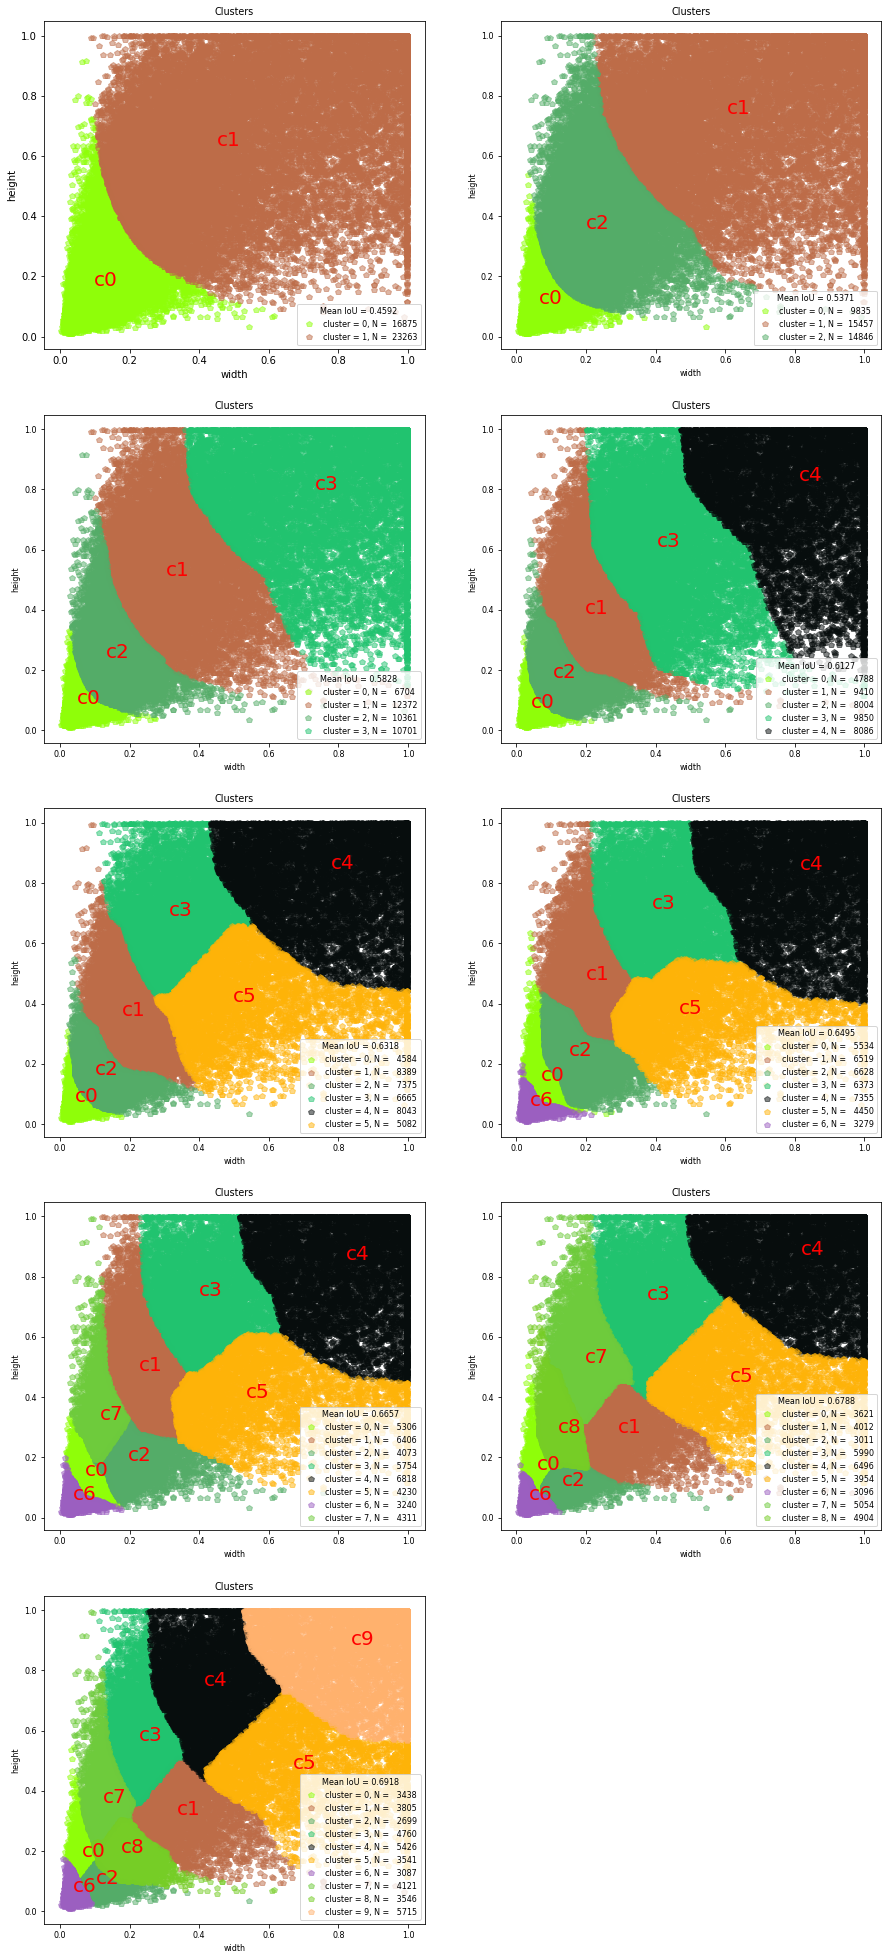

In [16]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh_box)
    count += 1
plt.show()

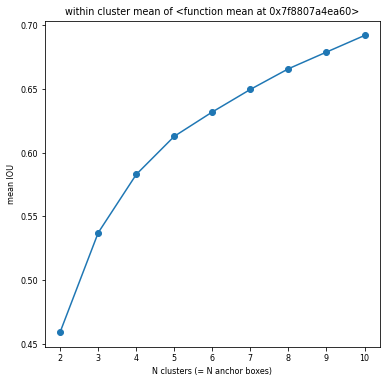

In [17]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [18]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[0.05      , 0.088     ],
       [0.304     , 0.512     ],
       [0.132     , 0.24      ],
       [0.734     , 0.79733333]])

# **Input encoding**

In [19]:
def normalize(image):
    return image / 255.
    
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        '''
        IMAGE_H : the height of the rescaled image, e.g., 416
        IMAGE_W : the width of the rescaled image, e.g., 416
        '''
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        # resize the image to standard size
        image = cv.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']

        image = cv.imread(image_name)
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

In [20]:
imageEncoder = ImageReader(416, 416, normalize)
image, objects = imageEncoder.fit(train_image[1])
objects

[{'name': 'aeroplane', 'xmin': 86, 'ymin': 115, 'xmax': 312, 'ymax': 270},
 {'name': 'aeroplane', 'xmin': 110, 'ymin': 130, 'xmax': 163, 'ymax': 182},
 {'name': 'person', 'xmin': 162, 'ymin': 266, 'xmax': 177, 'ymax': 339},
 {'name': 'person', 'xmin': 21, 'ymin': 279, 'xmax': 36, 'ymax': 352}]

# **Output 1 Encoding: Assign the best anchor box of the grid that contain object midpoint to the object**

In [21]:
anchor_boxes = np.array([0.05, 0.088, 0.132, 0.24, 0.304, 0.512, 0.734, 0.79733333])

In [22]:
class BoundBox():
  def __init__(self, x_min, y_min, x_max, y_max, confident=None, classes=None):
    self.x_min = x_min
    self.y_min = y_min
    self.x_max = x_max
    self.y_max = y_max
    self.confident = confident
    self.classes = classes
  
  def get_label(self):
    self.label = np.argmax(self.classes)

    return self.label

  def get_score(self):
    self.score = self.classes[self.label]

    return self.score

class FindBestAnchorBox():
  def __init__(self, anchors):
    self.anchors = [BoundBox(0, 0, anchors[2*i], anchors[2*i+1]) for i in range(int(len(anchors)//2))]

  def get_interval_overlap(self, box1, box2):
    x1, x2 = box1[0], box1[1]
    x3, x4 = box2[0], box2[1]

    if x1 > x3:
      if x1 > x4:
        return 0
      else:
        return min(x2, x4) - x1
    else:
      if x3 > x2:
        return 0
      else:
        return min(x4, x2) - x3
    
  def iou(self, box1, box2):
    w_overlap = self.get_interval_overlap([box1.x_min, box1.x_max], [box2.x_min, box2.x_max])
    h_overlap = self.get_interval_overlap([box1.y_min, box1.y_max], [box2.y_min, box2.y_max])

    intersection = w_overlap * h_overlap
    area1 = (box1.x_max - box1.x_min) * (box1.y_max - box1.y_min)
    area2 = (box2.x_max - box2.x_min) * (box2.y_max - box2.y_min)
    union = area1 + area2 - intersection

    iou = round(intersection / union, 2)
    
    return iou

  def find(self, w, h):
    box = BoundBox(0, 0, w, h)
    max_iou = -1
    best_anchor_box = -1


    for i in range(len(self.anchors)):
      anchor_box = self.anchors[i]
      current_iou = self.iou(box, anchor_box)
      if current_iou > max_iou:
        max_iou = current_iou
        best_anchor_box = i

    return best_anchor_box, max_iou


In [23]:
fbest = FindBestAnchorBox(anchor_boxes)
print('..'*40)
print("All anchor boxes:")
for i in range(len(fbest.anchors)):
  anchor = fbest.anchors[i]
  print("Anchor box number {} with w={}, h={}".format(i, anchor.x_max, anchor.y_max))
print('..'*40)
print('Best anchor box for some shape:')
for w in range(1, 9, 2):
  w = w / 10
  for h in range(1, 9, 2):
    h = h / 10

    anchor_box_id, iou = fbest.find(w, h)

    print("Box with w={} and h={} match with anchor box id={} and iou={}".format(w, h, anchor_box_id, iou))

................................................................................
All anchor boxes:
Anchor box number 0 with w=0.05, h=0.088
Anchor box number 1 with w=0.132, h=0.24
Anchor box number 2 with w=0.304, h=0.512
Anchor box number 3 with w=0.734, h=0.79733333
................................................................................
Best anchor box for some shape:
Box with w=0.1 and h=0.1 match with anchor box id=0 and iou=0.44
Box with w=0.1 and h=0.3 match with anchor box id=1 and iou=0.64
Box with w=0.1 and h=0.5 match with anchor box id=1 and iou=0.42
Box with w=0.1 and h=0.7 match with anchor box id=1 and iou=0.31
Box with w=0.3 and h=0.1 match with anchor box id=1 and iou=0.27
Box with w=0.3 and h=0.3 match with anchor box id=2 and iou=0.58
Box with w=0.3 and h=0.5 match with anchor box id=2 and iou=0.96
Box with w=0.3 and h=0.7 match with anchor box id=2 and iou=0.72
Box with w=0.5 and h=0.1 match with anchor box id=1 and iou=0.19
Box with w=0.5 and h=0.3 match w

# **Output Encoding 2:**

In [24]:
def rescale_xycenter(obj, config):
  # object: dictionary contains x_min, y_min, x_max, y_max
  # config: dict contains IMAGE_W, IMAGE_H, GRID_W, GRID_H

  x_center = (obj['xmin'] + obj['xmax']) / 2
  y_center = (obj['ymin'] + obj['ymax']) / 2

  x_center_grid = x_center / config['IMAGE_W'] * config['GRID_W']
  y_center_grid = y_center / config['IMAGE_H'] * config['GRID_H']

  return x_center_grid, y_center_grid

def rescale_whcenter(obj, config):
  w_center = obj['xmax'] - obj['xmin']
  h_center = obj['ymax'] - obj['ymin']

  w_center_grid = w_center / config['IMAGE_W'] * config['GRID_W']
  h_center_grid = h_center / config['IMAGE_H'] * config['GRID_H']

  return w_center_grid, h_center_grid

In [25]:
config = {'IMAGE_W': 416, 'IMAGE_H':416, 'GRID_W': 13, 'GRID_H':13}
imageEncoder = ImageReader(416, 416, normalize)
image, objects = imageEncoder.fit(train_image[1])
print(objects[0])
x_center, y_center = rescale_xycenter(objects[0], config)
print(x_center, y_center)
w_center, h_center = rescale_whcenter(objects[0], config)
print(w_center, h_center)

{'name': 'aeroplane', 'xmin': 86, 'ymin': 115, 'xmax': 312, 'ymax': 270}
6.21875 6.015625
7.062499999999999 4.84375


# **Batch Generator**

In [27]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = FindBestAnchorBox(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_xycenter(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_whcenter(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

In [28]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = anchor_boxes
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS 

array([ 0.65      ,  1.144     ,  1.716     ,  3.12      ,  3.952     ,
        6.656     ,  9.542     , 10.36533329])

In [29]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

In [30]:
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [31]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(iframe)

igrid_h=09,igrid_w=02,iAnchor=02, person
igrid_h=09,igrid_w=05,iAnchor=02, person
igrid_h=09,igrid_w=07,iAnchor=02, person
igrid_h=09,igrid_w=09,iAnchor=02, person


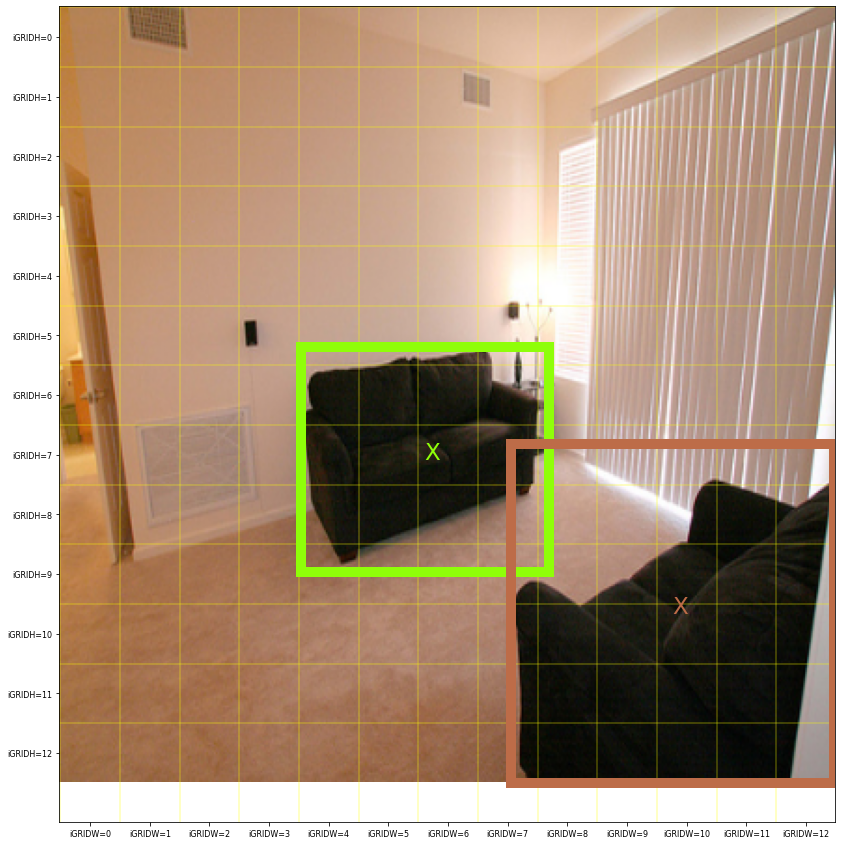

In [32]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

iframe=6
plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

In [33]:
for irow in range(5,10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Model**

In [34]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

def ConvBatchLReLu(x,filters,kernel_size,index,trainable):
    # when strides = None, strides = pool_size.
    x = Conv2D(filters, kernel_size, strides=(1,1), 
               padding='same', name='conv_{}'.format(index), 
               use_bias=False, trainable=trainable)(x)
    x = BatchNormalization(name='norm_{}'.format(index), trainable=trainable)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return(x)
def ConvBatchLReLu_loop(x,index,convstack,trainable):
    for para in convstack:
        x = ConvBatchLReLu(x,para["filters"],para["kernel_size"],index,trainable)
        index += 1
    return(x)
def define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, trainable=False):
    convstack3to5  = [{"filters":128, "kernel_size":(3,3)},  # 3
                      {"filters":64,  "kernel_size":(1,1)},  # 4
                      {"filters":128, "kernel_size":(3,3)}]  # 5
                    
    convstack6to8  = [{"filters":256, "kernel_size":(3,3)},  # 6
                      {"filters":128, "kernel_size":(1,1)},  # 7
                      {"filters":256, "kernel_size":(3,3)}]  # 8
    
    convstack9to13 = [{"filters":512, "kernel_size":(3,3)},  # 9
                      {"filters":256, "kernel_size":(1,1)},  # 10
                      {"filters":512, "kernel_size":(3,3)},  # 11
                      {"filters":256, "kernel_size":(1,1)},  # 12
                      {"filters":512, "kernel_size":(3,3)}]  # 13
        
    convstack14to20 = [{"filters":1024, "kernel_size":(3,3)}, # 14 
                       {"filters":512,  "kernel_size":(1,1)}, # 15
                       {"filters":1024, "kernel_size":(3,3)}, # 16
                       {"filters":512,  "kernel_size":(1,1)}, # 17
                       {"filters":1024, "kernel_size":(3,3)}, # 18
                       {"filters":1024, "kernel_size":(3,3)}, # 19
                       {"filters":1024, "kernel_size":(3,3)}] # 20
    
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3),name="input_image")
    true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4),name="input_hack")    
    # Layer 1
    x = ConvBatchLReLu(input_image,filters=32,kernel_size=(3,3),index=1,trainable=trainable)
    
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_416to208")(x)
    # Layer 2
    x = ConvBatchLReLu(x,filters=64,kernel_size=(3,3),index=2,trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_208to104")(x)
    
    # Layer 3 - 5
    x = ConvBatchLReLu_loop(x,3,convstack3to5,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_104to52")(x)
    
    # Layer 6 - 8 
    x = ConvBatchLReLu_loop(x,6,convstack6to8,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_52to26")(x) 

    # Layer 9 - 13
    x = ConvBatchLReLu_loop(x,9,convstack9to13,trainable)
        
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_26to13")(x)
    
    # Layer 14 - 20
    x = ConvBatchLReLu_loop(x,14,convstack14to20,trainable)

    # Layer 21
    skip_connection = ConvBatchLReLu(skip_connection,filters=64,
                                     kernel_size=(1,1),index=21,trainable=trainable)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = ConvBatchLReLu(x,filters=1024,kernel_size=(3,3),index=22,trainable=trainable)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS),name="final_output")(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    output = Lambda(lambda args: args[0],name="hack_layer")([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    return(model, true_boxes)

IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
CLASS             = len(LABELS)
## true_boxes is the tensor that takes "b_batch"
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [35]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2023-01-13 01:20:55--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  21.0MB/s    in 10s     

2023-01-13 01:21:06 (19.3 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [36]:
path_to_weight = "./yolov2.weights"

In [37]:
class WeightReader:
    # code from https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


In [38]:
def set_pretrained_weights(model, nb_conv, path_to_weight):
  weightReader = WeightReader(path_to_weight)
  weightReader.reset()

  for i in range(1, nb_conv+1):
    conv = model.get_layer('conv_'+str(i))

    if i < nb_conv:
      norm = model.get_layer('norm_'+str(i))

      size = np.prod(norm.get_weights()[0].shape)

      beta  = weight_reader.read_bytes(size)
      gamma = weight_reader.read_bytes(size)
      mean  = weight_reader.read_bytes(size)
      var   = weight_reader.read_bytes(size)

      weights = norm.set_weights([beta, gamma, mean, var])

    if len(conv.get_weights()) > 1: # with bias
      bias_size = np.prod(conv.get_weights()[1].shape)  
      bias = weight_reader.read_bytes(bias_size)

      kernel_size = np.prod(conv.get_weights()[0].shape)  
      kernel = weight_reader.read_bytes(bias_size)
      kernel = kernel.reshape(list(reversed(conv.get_weights()[0].shape)))
      kernel = kernel.transpose([2,3,1,0])
      conv.set_weights([kernel, bias])
    else: ## without bias
      kernel = weight_reader.read_bytes(np.prod(conv.get_weights()[0].shape))
      kernel = kernel.reshape(list(reversed(conv.get_weights()[0].shape)))
      kernel = kernel.transpose([2,3,1,0])
      conv.set_weights([kernel])
    return model

In [39]:
nb_conv = 22
model = set_pretrained_weights(model,nb_conv, path_to_weight)

In [40]:
def initialize_weight(layer,sd):
    weights = layer.get_weights()
    new_kernel = np.random.normal(size=weights[0].shape, scale=sd)
    new_bias   = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([new_kernel, new_bias])
    
layer   = model.layers[-4] # the last convolutional layer
initialize_weight(layer,sd=GRID_H*GRID_W)

In [41]:
    
layer   = model.layers[-4] # the last convolutional layer
initialize_weight(layer,sd=GRID_H*GRID_W)

# **Loss**

**Rescale Prediction Output**

In [70]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [42]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return cell_grid

def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class 

In [44]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return true_box_xy, true_box_wh, true_box_conf, true_box_class

**Example of prediction and label**

In [49]:
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy_tf,   pred_box_wh_tf, 
 pred_box_conf_tf, pred_box_class_tf) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)

y_pred before scaling = (16, 13, 13, 4, 25)
******************************
define tensor graph


In [50]:
y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy_tf, true_box_wh_tf, 
 true_box_conf_tf, true_box_class_tf) = extract_ground_truth(y_batch_tf)

**Loss 1 : Loss in x, y, w, h**

In [84]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
  coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
  nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
  loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
  loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
  return loss_xy + loss_wh, coord_mask

In [60]:
LAMBDA_COORD = 1
loss_xywh_tf, coord_mask_tf  = loss_xywh(true_box_conf_tf,LAMBDA_COORD,
                                               true_box_xy_tf, pred_box_xy_tf,true_box_wh_tf,pred_box_wh_tf)
loss_xywh_tf

<tf.Tensor: shape=(), dtype=float32, numpy=3.3892965>

**Loss 2: Loss in class**

In [85]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)

In [58]:
LAMBDA_CLASS   = 1
loss_class_tf  = calc_loss_class(true_box_conf_tf,LAMBDA_CLASS,
                                 true_box_class_tf,pred_box_class_tf)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0086067>

**Loss 3: Loss in confidence**

In [61]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):

    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)

In [64]:
true_box_conf_IOU_tf = calc_IOU_pred_true_assigned(
                            true_box_conf_tf,
                            true_box_xy_tf, true_box_wh_tf,
                            pred_box_xy_tf,  pred_box_wh_tf)
true_box_conf_IOU_tf.shape

TensorShape([16, 13, 13, 4])

In [66]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)

In [68]:
true_boxes_tf = tf.constant(b_batch,dtype="float32")
best_ious_tf = calc_IOU_pred_true_best(pred_box_xy_tf,
                                       pred_box_wh_tf,
                                       true_boxes_tf)
best_ious_tf.shape

TensorShape([16, 13, 13, 4])

In [72]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

In [73]:
conf_mask_tf = get_conf_mask(best_ious_tf, 
                             true_box_conf_tf, 
                             true_box_conf_IOU_tf,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
conf_mask_tf.shape

TensorShape([16, 13, 13, 4])

In [76]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  

    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

In [77]:
loss_conf_tf = calc_loss_conf(conf_mask_tf,true_box_conf_IOU_tf, pred_box_conf_tf)
loss_conf_tf

<tf.Tensor: shape=(), dtype=float32, numpy=0.12473706>

**Final Loss**

In [90]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category <iclass> else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss

# **Train**

In [94]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
ANCHORS = np.array([0.05, 0.088, 0.132, 0.24, 0.304, 0.512, 0.734, 0.79733333])

train_image_folder = "/content/VOC2012/JPEGImages/"
train_annot_folder = "/content/VOC2012/Annotations/"

np.random.seed(1)
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("N train = {}".format(len(train_image)))

BATCH_SIZE        = 200
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

CLASS             = len(LABELS)
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)

path_to_weight = "./yolov2.weights"
nb_conv        = 22
model          = set_pretrained_weights(model,nb_conv, path_to_weight)
layer          = model.layers[-4] # the last convolutional layer
initialize_weight(layer,sd=1/(GRID_H*GRID_W))

N train = 17125


In [93]:
GRID_W             = 13
GRID_H             = 13
BATCH_SIZE         = 34
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [95]:
def custom_loss_core(y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT):

    BOX = int(len(ANCHORS)/2)    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
    loss = loss_xywh + loss_conf + loss_class
    return(loss)

def custom_loss(y_true, y_pred):
    loss = custom_loss_core(y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT)

    
    return loss


In [96]:
dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


BATCH_SIZE   = 32
generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_yolo_on_voc2012.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)


optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [97]:
model.fit_generator(generator        = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 50, 
                    verbose          = 1,
                    #validation_data  = valid_batch,
                    #validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

<ipython-input-97-b8dac46f0144>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator        = train_batch_generator,


Epoch 1/50


TypeError: ignored